In [1]:
import numpy as np
import argparse
import dlib
import cv2
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import imutils
from imutils import face_utils
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/mouth_dataset_split.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Shared.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/Shared/shape_predictor_68_face_landmarks.dat')


In [6]:
def get_data(direc):
    X =[]
    y = []
    IMG_SIZE = 50
    categories = os.listdir(direc)
    for category in categories:
        path_link = os.path.join(direc, category)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image),cv2.IMREAD_GRAYSCALE)
            image_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            X.append(image_array)
            y.append(int(category))
    return X,y



In [7]:
X_train,y_train = get_data("/content/mouth_dataset_split/train")
X_test,y_test = get_data("/content/mouth_dataset_split/test")

In [8]:
X_train = np.array(X_train).reshape(-1,50,50,1)
X_test = np.array(X_test).reshape(-1,50,50,1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [9]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)
y_train = y_train.flatten()
y_test = y_test.flatten()

In [10]:
train_dir = "/content/mouth_dataset_split/train"
test_dir = "/content/mouth_dataset_split/test"

In [11]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=2,
                                   zoom_range=0.2,
                                   validation_split=0.2, 
                                   dtype=np.float32)

In [12]:
batch_train = 2048
batch_val = 512

In [13]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,  # Source directory
    target_size=(50, 50),  # Resized
    batch_size=batch_val,
    color_mode='grayscale',
    subset='validation',
    class_mode='binary')

Found 807 images belonging to 2 classes.


In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Source directory
    target_size=(50, 50),  #Resized to this size
    batch_size=batch_train,
    color_mode='grayscale',
    subset='training',
    class_mode='binary')

Found 3234 images belonging to 2 classes.


In [15]:
learning_rate = 0.0001
adam = Adam(lr=learning_rate)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor = 'val_loss',
                          min_delta = 0, #minimium amount of change to count as an improvement
                          patience = 10, # how many epochs to wait before stopping
                          verbose = 1,
                          restore_best_weights = True),
    ReduceLROnPlateau(factor=0.9, patience=10, min_lr=0.001),
    ModelCheckpoint('MouthModel.h5', verbose=1, save_best_only=True)#, save_weights_only=True
]

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", input_shape=X_test.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         7

In [18]:
#history2 = model2.fit(X_train,y_train, batch_size=batch, epochs=100, validation_split=0.2,shuffle = True, verbose=1,callbacks=callbacks)
history2 = model.fit(train_generator, epochs=300, shuffle=True, validation_data=validation_generator, validation_steps=validation_generator.samples//batch_val,steps_per_epoch=train_generator.samples//batch_train, callbacks=callbacks)

Epoch 1/300
1/1 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.5211
Epoch 1: val_loss improved from inf to 0.70032, saving model to MouthModel.h5
1/1 [==============================] - 12s 12s/step - loss: 0.6938 - accuracy: 0.5211 - val_loss: 0.7003 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/300
1/1 [==============================] - ETA: 0s - loss: 0.7037 - accuracy: 0.4722
Epoch 2: val_loss improved from 0.70032 to 0.68655, saving model to MouthModel.h5
1/1 [==============================] - 3s 3s/step - loss: 0.7037 - accuracy: 0.4722 - val_loss: 0.6865 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 3/300
1/1 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5767
Epoch 3: val_loss improved from 0.68655 to 0.68305, saving model to MouthModel.h5
1/1 [==============================] - 5s 5s/step - loss: 0.6874 - accuracy: 0.5767 - val_loss: 0.6830 - val_accuracy: 0.5996 - lr: 0.0010
Epoch 4/300
1/1 [==============================] - ETA: 0s -

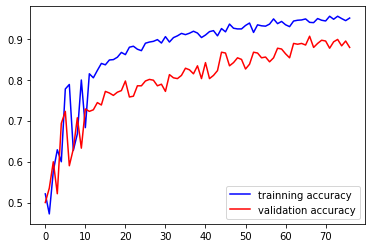

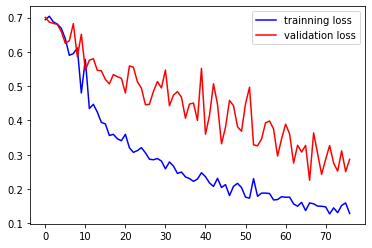

Model Evaluation
Loss: 0.114
Accuracy: 0.965



In [20]:
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

(loss,acc) = model.evaluate(X_test,y_test, verbose=0)
print('Model Evaluation')
print('Loss: %.3f' % loss)
print('Accuracy: %.3f' % acc)
print()